In [1]:
#import libraries
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import fbprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


import plotly.plotly as py
import plotly.graph_objs as go


%matplotlib inline
plt.style.use('fivethirtyeight')

## Data Prep

**Master**

In [2]:
master_df = pd.read_pickle('dt_master.pickle')

In [3]:
master_df.head(1)

,net_approval,Price,compound,sentiment,trump_kw,trump_mueller_kw
2017-01-23,4.400803,19799.85,0.4939,0.0,100.0,0.0


**Approval Ratings**

In [4]:
dt_ratings = pd.read_pickle('dt_ratings.pickle')

In [5]:
dt_ratings.head(1)

,approve_estimate,disapprove_estimate,net_approval
modeldate,,,
2017-01-23,45.488977,41.088173,4.400803


**DJIA Price Data**

In [6]:
djia_df = pd.read_pickle('djia_data.pickle')

In [7]:
djia_df.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [8]:
djia_df.head(1)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-18,24706.35,"24,534.19","24,750.22","24,459.03",372.97,1.38%


**Trump Twitter Data**

In [9]:
dt_tweets = pd.read_pickle('dt_tweets.pickle')

In [10]:
dt_tweets.index = dt_tweets['date']

In [11]:
dt_tweets.head(1)

,text,date,neg,neu,pos,compound,sentiment
date,,,,,,,
2017-01-23,Busy week planned with a heavy focus on jobs a...,2017-01-23,0.0,0.826,0.174,0.4939,0


### Create Dataframes

**Convert to Format**

In [26]:
#DJIA Price Data
djia_price = pd.DataFrame({"ds": djia_df.index, "y": djia_df.Price})
djia_price.reset_index(drop = True, inplace = True)

In [27]:
#DJIA percent change
djia_percent = pd.DataFrame({"ds": djia_df.index, "y": djia_df['Change %']})
djia_percent['y'] = djia_percent['y'].apply(lambda x: x.replace('%', ''))
djia_percent.reset_index(drop = True, inplace = True)

In [28]:
#Approval Rating
approvals = pd.DataFrame({"ds": dt_ratings.index, "approvals": dt_ratings.approve_estimate})
approvals.reset_index(drop = True, inplace = True)

In [29]:
#Diapproval Rating
disapprovals = pd.DataFrame({"ds": dt_ratings.index, "y": dt_ratings.disapprove_estimate})
disapprovals.reset_index(drop = True, inplace = True)

In [30]:
#Net Approval Rating
net_rating = pd.DataFrame({"ds": dt_ratings.index, "y": dt_ratings.net_approval})
net_rating.reset_index(drop = True, inplace = True)

In [31]:
#Trump Google Trends
trump_kw = pd.DataFrame({"ds": master_df.index, "y": master_df.trump_kw})
trump_kw.reset_index(drop = True, inplace = True)

In [32]:
# Trump Mueller Google Trends
trump_mueller_kw = pd.DataFrame({"ds": master_df.index, "y": master_df.trump_mueller_kw})
trump_mueller_kw.reset_index(drop = True, inplace = True)

**Combined**

In [33]:
#DJIA Percent & Approvals Regressor
percent_approvals = djia_percent
percent_approvals['approvals'] = approvals.approvals

### Split Data

In [34]:
#Split Data

train_djia = djia_percent[:int(0.8*(len(djia_percent)))]
test_djia = djia_percent[int(0.8*(len(djia_percent))):]

In [35]:
train_djiap = djia_price[:int(0.8*(len(djia_percent)))]
test_djiap = djia_price[int(0.8*(len(djia_percent))):]

## Modeling

###  Model 1 (Price)

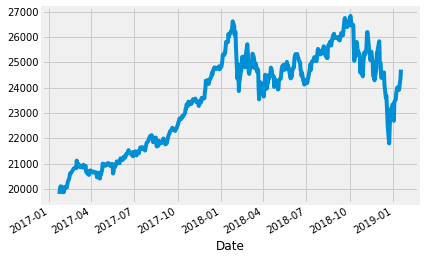

In [36]:
djia_df['Price'].plot()

In [37]:
model = Prophet()
model.fit(djia_price);
future = model.make_future_dataframe(periods=105) #forecasting for 1 year from now.
forecast = model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


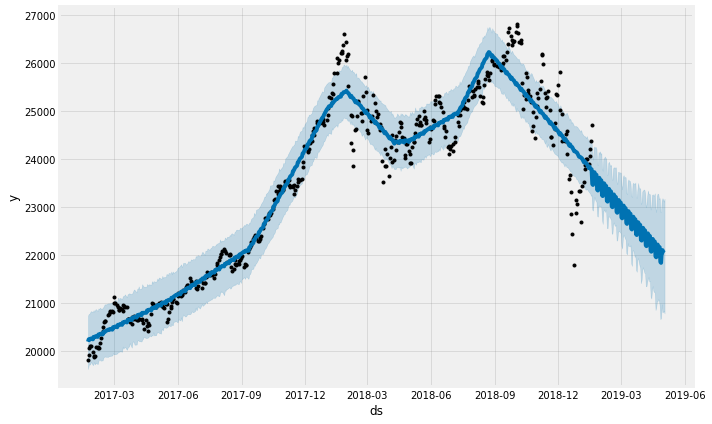

In [38]:
figure = model.plot(forecast)

In [39]:
df_cv = cross_validation(model, initial='365 days', horizon = '102 days')
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-01-26 00:00:00 and 2018-10-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-29,26213.243010,26013.578555,26412.685688,26439.48,2018-01-26
1,2018-01-30,26244.795403,26049.868954,26428.146781,26076.89,2018-01-26
2,2018-01-31,26286.412955,26097.119634,26474.268340,26149.39,2018-01-26
3,2018-02-01,26327.767001,26134.865834,26528.197325,26186.71,2018-01-26
4,2018-02-02,26379.194481,26166.563785,26575.588798,25520.96,2018-01-26


In [40]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
289,10 days,834711.983374,913.625735,785.662567,0.031688,0.190476
290,11 days,845443.317672,919.479917,800.208488,0.032245,0.166667
362,11 days,875465.977155,935.663389,817.875839,0.032918,0.166667
78,11 days,897463.849735,947.345687,829.897780,0.033428,0.166667
6,11 days,947487.025078,973.389452,852.410802,0.034324,0.166667


### Model 2 (Price - Not auto)

In [41]:
prophet_data.info()

NameError: name 'prophet_data' is not defined

In [ ]:
prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.8)

In [ ]:
prophet_model.fit(prophet_data)

In [ ]:
prophet_forecast = prophet_model.make_future_dataframe(periods=30, freq='D')
prophet_forecast = prophet_model.predict(prophet_forecast)
prophet_model.plot(prophet_forecast, xlabel = 'Date', ylabel = 'Stock Price')
plt.title('Future DJIA Prices')

In [ ]:
fig = prophet_model.plot_components(prophet_forecast)

In [ ]:
#fig = prophet_model.plot(prophet_forecast)
#a = add_changepoints_to_plot(fig.gca(), prophet_model, prophet_forecast)

In [ ]:
df_cv = cross_validation(prophet_model, initial='365 days', horizon = '100 days')

In [ ]:
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')


### Model 3 (Percent Change)

In [ ]:
djia_percent.head(1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


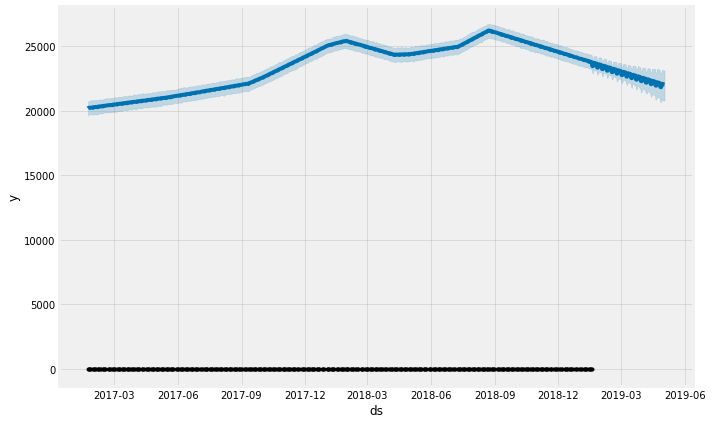

In [43]:
mod3 = Prophet()
mod3.fit(djia_percent)
forcast = mod3.predict(future)
fig = mod3.plot(forecast)

In [45]:
df3_cv = cross_validation(mod3, initial='365 days', horizon = '100 days', period ='10')

KeyboardInterrupt: 

In [ ]:
df3_cv.head(1)

In [42]:
df_p3 = performance_metrics(df3_cv)
df_p3.head(12)

NameError: name 'df3_cv' is not defined

In [55]:
djia_percent.head()

,ds,y,approvals
0,2019-01-18,1.38,45.488977
1,2019-01-17,0.67,45.480880
2,2019-01-16,0.59,47.325433
3,2019-01-15,0.65,44.073550
4,2019-01-14,-0.36,43.868173


In [3]:
data = [go.Scatter(
          x=djia_percent[ds],
          y=djia_percent['y'])]

py.iplot(data)

NameError: name 'djia_percent' is not defined

In [ ]:
fig = plot_cross_validation_metric(df3_cv, metric='mape')

### Add Regressors

In [71]:
percent_approvals.head(1)

,ds,y,approvals
0,2019-01-18,1.38,45.488977


In [74]:
percent_approvals.approvals = percent_approvals.approvals.fillna(method='bfill')